# Sequential colour maps with adjustable contrast and bias
Gilles Ferrand<br>
2019-08-28

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
print matplotlib.__version__
%matplotlib inline

2.1.1


## Karma's version: Greyscale3

code extracted from https://github.com/rgooch/karma/blob/master/source/lib/karma/packages/cf/misc1.c

In [2]:
def ef(x,c,x0):
    y = np.exp ( c * (x - x0) )
    return y / (y+1)

In [3]:
def curve_Karma(x, y):
    """the Glynn Rogers curvature function"""
    x0 = np.float(x)
    c = np.float(y*12)
    if c <= 0: c = 0.001
    offset = ef(0., c, x0)
    denominator = ef(1., c, x0) - offset
    if denominator <= 0: denominator = 0.1
    func = lambda value: (ef(value, c, x0) - offset) / denominator
    # NB: in Matplotlib a colour is a float in [0,1] rather than an integer in [0,65535]
    return func

In [4]:
def stripchart(func, num_cells=256):
    # func maps [0,1] to [0,1]
    ramp = np.linspace(0,1,num_cells)
    table = np.array(map(func, ramp))
    table[np.where(table<0)] = 0
    table[np.where(table>1)] = 1
    return table

In [5]:
def showgrid_curves(x, y, func, num_cells=100):
    fig, axes = plt.subplots(len(y),len(x),sharex=True,sharey=True,
                             figsize=(10/3.*len(x),10/3.*len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            ax_ij = axes[j,i] if len(x)*len(y)>1 else axes
            values_in  = np.linspace(0,1,num_cells)
            values_out = stripchart(func(x[i],y[j]),num_cells)
            ax_ij.plot(values_in, values_out)
            ax_ij.set_title("x = %.1f, y = %.1f"%(x[i],y[j]))
            ax_ij.xaxis.set_ticks(np.linspace(0,1,5))
            ax_ij.yaxis.set_ticks(np.linspace(0,1,5))

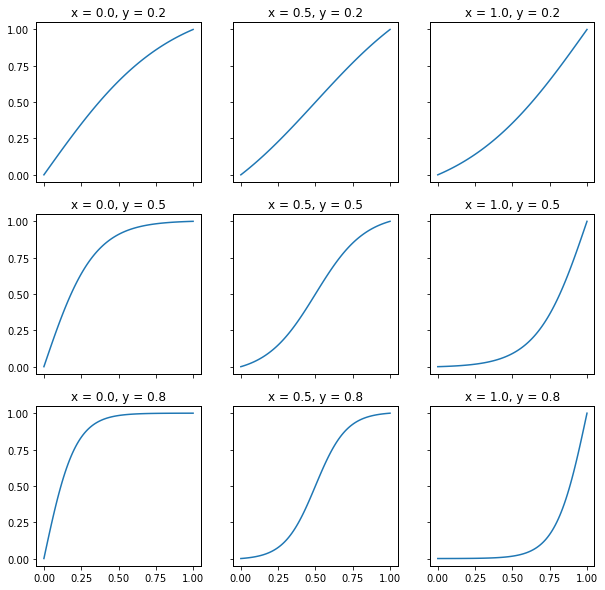

In [6]:
x = [0.0, 0.5, 1.0]
y = [0.2, 0.5, 0.8]
showgrid_curves(x, y, curve_Karma)

parameter y sets the steepness of the transition<br>
parameter x sets the position of the transition

### Original implementation: stretch inside the colour map

creating custom colout maps with Matplotlib: <br>https://matplotlib.org/tutorials/colors/colormap-manipulation.html

In [7]:
def greyscale3(x, y, func, num_cells=256):
    """the Grayscale3 colour map for Matplotlib"""
    values = stripchart(func(x,y),num_cells) # in [0,1]
    RGB_list = np.transpose(np.tile(values, (3,1)))
    cmap = matplotlib.colors.ListedColormap(RGB_list,'Greyscale3')
    return cmap

test data

In [8]:
x = np.arange(0, 2*np.pi, 0.01)
y = np.arange(0,   np.pi, 0.01)
X,Y = np.meshgrid(x,y)
Z = -np.sin(X)*np.sin(Y)

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def showgrid_images(x,y,cmap,norm,ticks):
    # x,y are arrays of parameters
    # cmap,norm,ticks are functions of (x,y)
    fig, axes = plt.subplots(len(y),len(x),sharex=True,sharey=True,
                             figsize=(1.1*10/3.*len(x),10/3.*len(y)))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for i in range(len(x)):
        for j in range(len(y)):
            ax_ij = axes[j,i] if len(x)*len(y)>1 else axes
            im = ax_ij.imshow(Z, cmap=cmap(x[i],y[j]), norm=norm(x[i],y[j]), aspect='auto', interpolation='nearest')
            cax = make_axes_locatable(ax_ij).append_axes("right", size="10%", pad=0.1)
            #ticks = matplotlib.ticker.MultipleLocator(0.5)
            cbar = plt.colorbar(im, cax=cax, ticks=ticks(x[i],y[j]), format="%.2f")
            ax_ij.set_title("x = %.1f, y = %.1f"%(x[i],y[j]))
            ax_ij.axis('off')

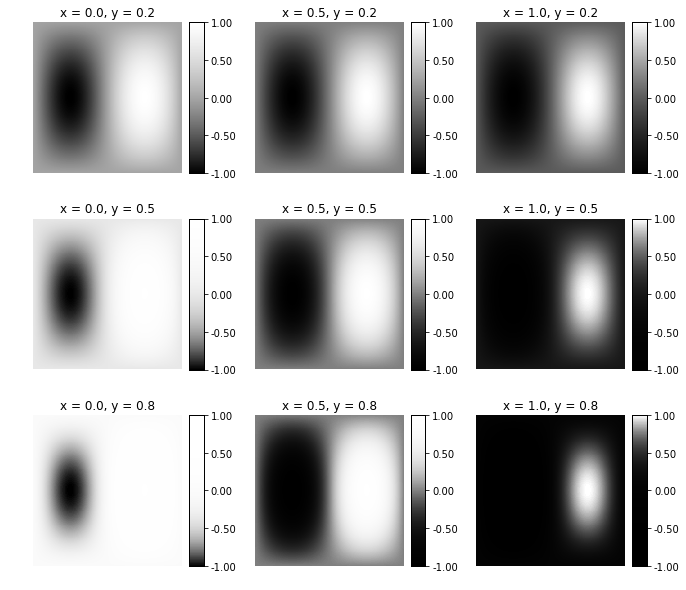

In [10]:
x = [0.0, 0.5, 1.0]
y = [0.2, 0.5, 0.8]
cmap_xy  = lambda x,y: greyscale3(x,y,curve_Karma)
norm_xy  = lambda x,y: matplotlib.colors.Normalize(vmin=-1,vmax=+1)
ticks_xy = lambda x,y: np.linspace(-1,+1,5)
showgrid_images(x, y, cmap_xy, norm_xy, ticks_xy)

Note how the colour bar changes: it is the colour map that gets stretched, the data values stay the same.

The ticks are regularly spaced in data space. Alternatively one can sample them on the colour map, to make the stretch apparent. On the plot below, ticks are at 0%, 25%, 50%, 75% ,100% lightness, on each colour bar.

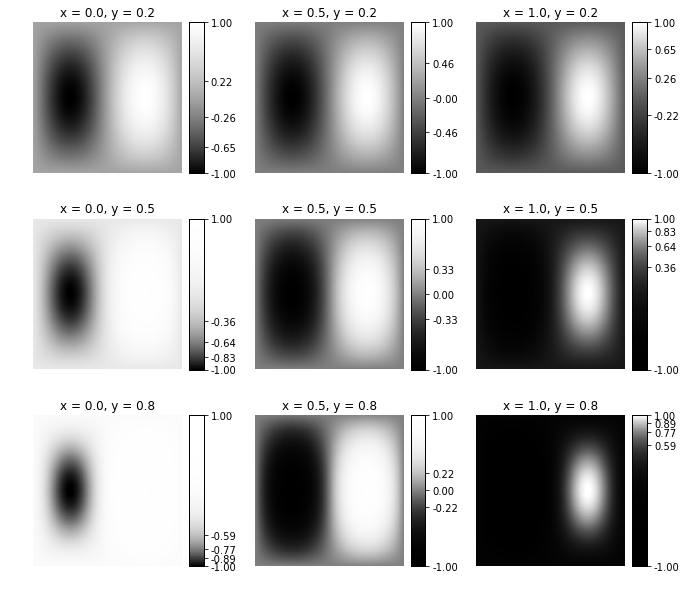

In [11]:
ticks = np.linspace(0,1,5)
ticks_xy = lambda x,y: np.interp(ticks, stripchart(curve_Karma(x,y),100), np.linspace(-1,+1,100))
showgrid_images(x, y, cmap_xy, norm_xy, ticks_xy)

### Alternate implementation: stretch before applying the colour map

Let's re-do this by applying the stretch to the data, using a fixed linear greyscale colour map.

Colour map normalization with Matplotlib: <br>
https://matplotlib.org/tutorials/colors/colormapnorms.html

In [12]:
class Greyscale3(matplotlib.colors.Normalize):
    """the Greyscale3 curvature function, redux"""
    
    def __init__(self, vmin=None, vmax=None, clip=False, x=0.5, y=0.0, curve=curve_Karma, num_cells=1000):
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)
        self.levels = np.linspace(0,1, num_cells)
        self.normed = stripchart(curve(x,y), num_cells)

    def __call__(self, value, clip=None):
        # (ignoring masked values and clipping)
        value = (value - self.vmin) / (self.vmax - self.vmin)
        value = np.interp(value, self.levels, self.normed)
        return np.ma.masked_array(value)

    def inverse(self, value):
        # needs to be defined, used to put the ticks
        value = np.interp(value, self.normed, self.levels)
        value = self.vmin + (self.vmax - self.vmin) * value
        return np.ma.masked_array(value)

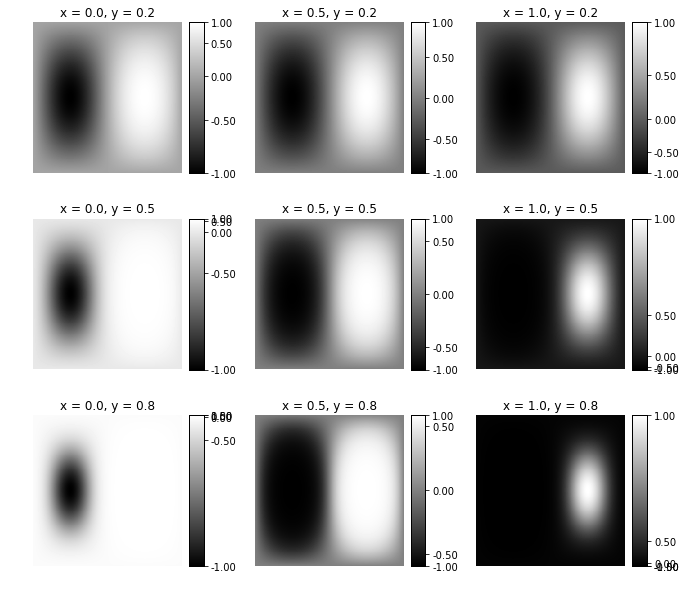

In [13]:
x = [0.0, 0.5, 1.0]
y = [0.2, 0.5, 0.8]
RGB_list = np.transpose(np.tile(np.linspace(0,1,256), (3,1)))
cmap_xy  = lambda x,y: matplotlib.colors.ListedColormap(RGB_list)
norm_xy  = lambda x,y: Greyscale3(vmin=-1,vmax=+1,x=x,y=y,curve=curve_Karma)
ticks_xy = lambda x,y: np.linspace(-1,+1,5)
showgrid_images(x, y, cmap_xy, norm_xy, ticks_xy)

Note how the ticks are automatically placed at the requested data values. <br>(Where the function is steep, it gets crowded, one would want less of them.)

Alternatively, one can enforce regularly spaced ticks, but this implies irregularly sampled data values (then the stretching applied is not immediately visible).

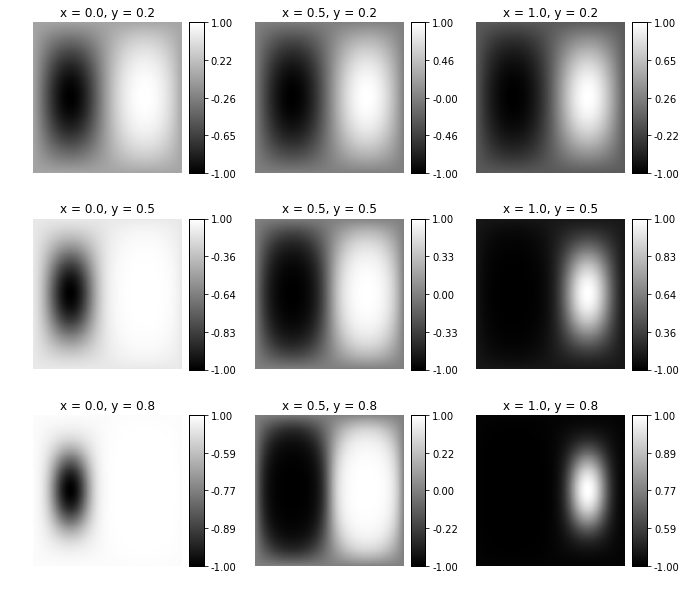

In [14]:
ticks_xy = lambda x,y: norm_xy(x,y).inverse(np.linspace(0,1,5))
showgrid_images(x, y, cmap_xy, norm_xy, ticks_xy)

In any case, the colour bar must be labelled with the original data values, not the transformed ones.

## DS9 version: contrast and bias

code extracted from https://github.com/ericmandel/js9/blob/master/js9.js

In [15]:
def curve_DS9(x, y):
    """DS9 curvature function"""
    def calcContrastBias(i, bias, contrast, invert=False):
        if invert: bias = 1 - bias
        # shift by bias, multiply by contrast, shift to center of region
        r = (np.float(i) - bias) * contrast + 0.5
        # NB: in Matplotlib a colour is already a float in [0,1], rather than an integer in [0,1024-1]
        return max(min(r,1),0)
    func = lambda value: calcContrastBias(value, x, y*10) # (x,y) is the mouse input
    return func

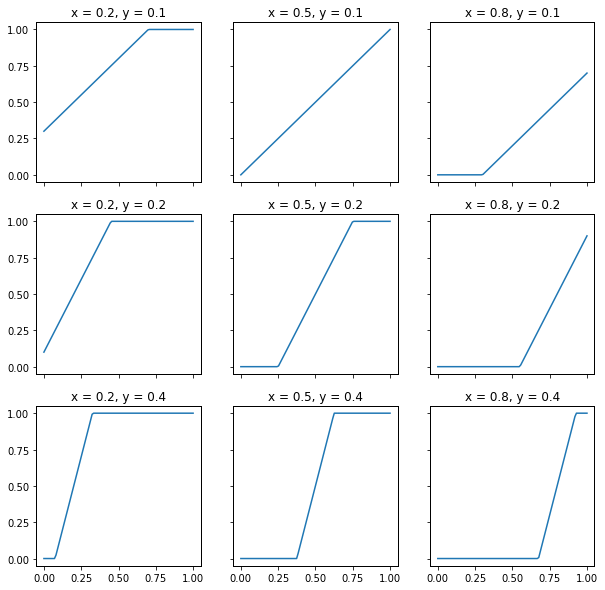

In [16]:
x = [0.2, 0.5, 0.8]
y = [0.1, 0.2, 0.4] # different range than before, because different definition
showgrid_curves(x, y, curve_DS9)

What the curve does is to shrink (y="contrast") and shift (x="bias") the range that is (linearly) mapped.<br>
Karma does something similar but in a smooth way. Also, note that the linear ramp may cut at the edges, so that the effective dynamic range is reduced, whereas Karma's curve always goes all the way from 0 to 1.

Let's see their effect on the image.

### Original implementation: stretch inside the colour map

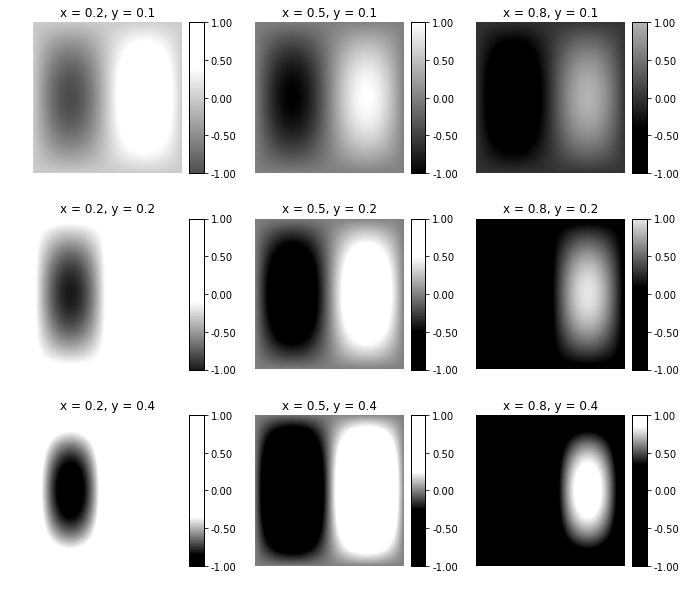

In [17]:
cmap_xy  = lambda x,y: greyscale3(x,y,curve_DS9)
norm_xy  = lambda x,y: matplotlib.colors.Normalize(vmin=-1,vmax=+1)
ticks_xy = lambda x,y: np.linspace(-1,+1,5)

showgrid_images(x, y, cmap_xy, norm_xy, ticks_xy)

### Alternate implementation: stretch before applying the colour map

Beware: because the normalizer is not mapping to the full range [0,1], the automatic placement of ticks is not working properly. In some edges cases the plotting may even fail. So setting the ticks by hand, which is a complication.

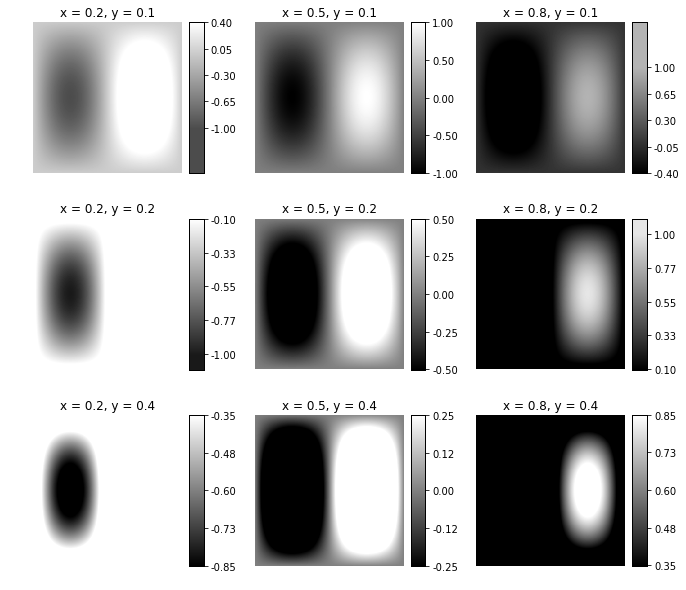

In [18]:
cmap_xy  = lambda x,y: matplotlib.colors.ListedColormap(RGB_list)
norm_xy  = lambda x,y: Greyscale3(vmin=-1,vmax=+1,x=x,y=y,curve=curve_DS9)

def ticks_xy(x,y):
    # the normalizer object defined above contains the info we need
    norm = norm_xy(x,y)
    # the actual range of data values mapped
    vmin = norm.levels[np.where(norm.normed>0)[0][ 0]]
    vmax = norm.levels[np.where(norm.normed<1)[0][-1]]
    vmin = norm.vmin + (norm.vmax - norm.vmin) * vmin
    vmax = norm.vmin + (norm.vmax - norm.vmin) * vmax
    # extra safety check...
    if vmin == -1: vmin = -0.999
    if vmax == +1: vmax = +0.999
    #print "x = %.1f, y = %.1f: vmin = %+.2f, vmax = %+.2f"%(x,y,vmin,vmax)
    # set 5 equi-distant ticks
    ticks = np.linspace(vmin,vmax,5)
    return ticks

showgrid_images(x, y, cmap_xy, norm_xy, ticks_xy)

As noted before, at large enough bias, not the entire greyscale range is used. <br>And at large contrast, maps look harsher than in the Karma's version.